# Structure selection strategies

This notebooks compares different strategies to pick the most reasonable structure/docking result, i.e. docking score or Posit probability and 2D or 3D similarity of the molecule to dock and the co-crystallized ligand.

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.utils import resample

In [2]:
sns.set() # Setting seaborn as default style even if use only matplotlib

In [3]:
OUT_DIR = Path("../pics")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
fred_results = pd.read_csv("../data/fred_results.csv", index_col=0)
hybrid_results = pd.read_csv("../data/hybrid_results.csv", index_col=0)
posit_results = pd.read_csv("../data/posit_results.csv", index_col=0)

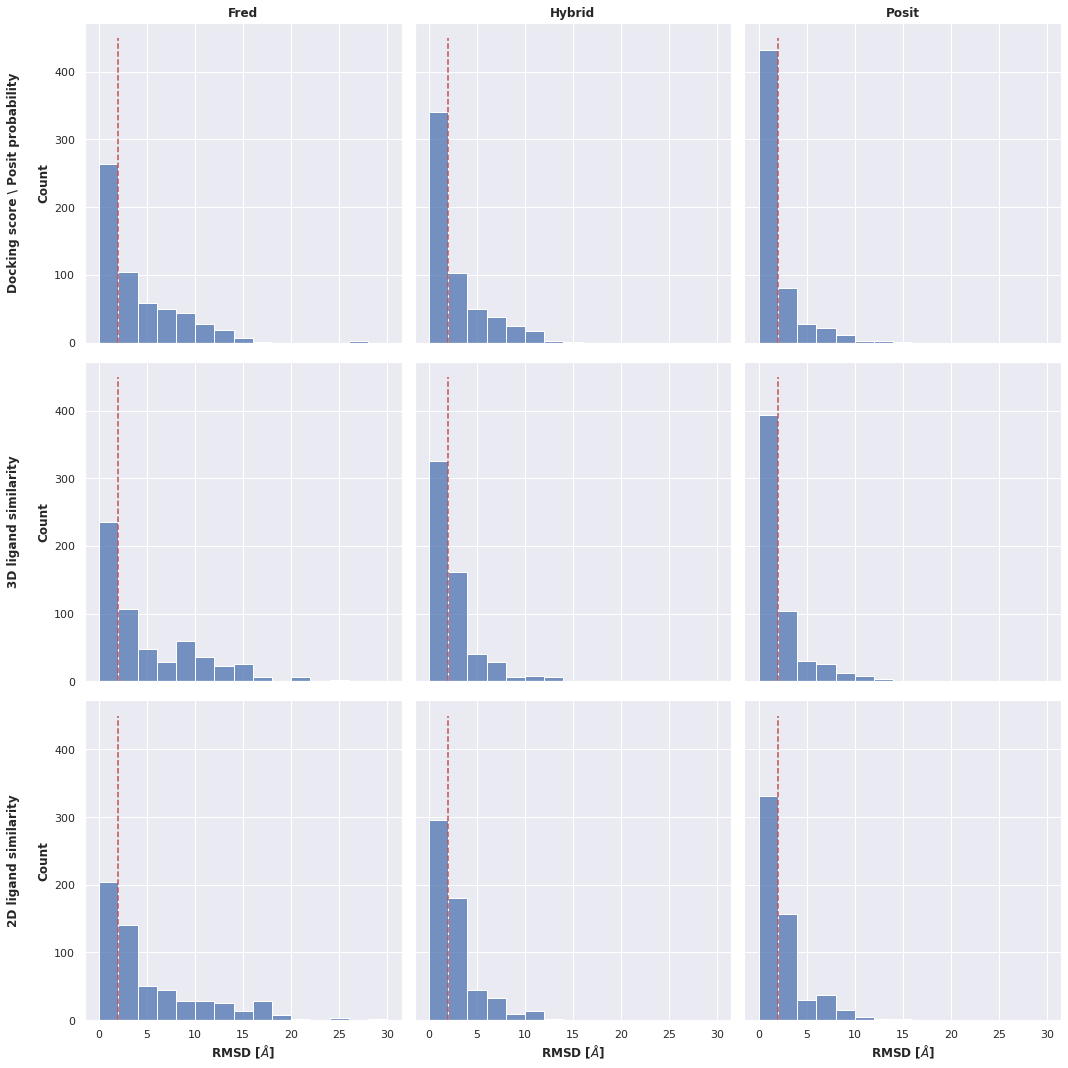

In [5]:
def plot_selection_strategies(fred_results, hybrid_results, posit_results, n_bootstrap=1000, ci=0.95, directory=OUT_DIR):
    
    # select pose 1 for Fred and Hybrid, i.e. best pose according to docking score
    fred_results = fred_results[fred_results["pose"] == 1]
    hybrid_results = hybrid_results[hybrid_results["pose"] == 1]
    
    # 9 subplots
    fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(15, 15))
    
    ## docking score and/or posit probability
    # sort
    fred_results = fred_results.sort_values("docking_score")
    fred_results_picked = fred_results.groupby(["ligand_pdb_id"]).head(1)
    hybrid_results = hybrid_results.sort_values("docking_score")
    hybrid_results_picked = hybrid_results.groupby(["ligand_pdb_id"]).head(1)
    posit_results = posit_results.sort_values("docking_score")
    posit_results = posit_results.sort_values("posit_probability", ascending=False)
    posit_results_picked = posit_results.groupby(["ligand_pdb_id"]).head(1)
    
    # plot data
    bins = range(0, int(max(fred_results["rmsd"].max(), hybrid_results["rmsd"].max(), posit_results["rmsd"].max())), 2)
    sns.histplot(data=fred_results_picked, x="rmsd", bins=bins, ax=axes[0][0])
    sns.histplot(data=hybrid_results_picked, x="rmsd", bins=bins, ax=axes[0][1])
    sns.histplot(data=posit_results_picked, x="rmsd", bins=bins, ax=axes[0][2])
    
    # titles
    axes[0][0].set_ylabel("Docking score \\ Posit probability\n\nCount", fontweight="bold")
    axes[0][0].set_title("Fred", fontweight="bold")
    axes[0][0].set_xlabel("")
    axes[0][1].set_title("Hybrid", fontweight="bold")
    axes[0][1].set_xlabel("")
    axes[0][2].set_title("Posit", fontweight="bold")
    axes[0][2].set_xlabel("")
    
    # plot 2 A cutoff
    axes[0][0].vlines(2, ymin=0, ymax=450, colors="r", linestyles="dashed")
    axes[0][1].vlines(2, ymin=0, ymax=450, colors="r", linestyles="dashed")
    axes[0][2].vlines(2, ymin=0, ymax=450, colors="r", linestyles="dashed")
    
    ## 3D similarity
    # sort
    fred_results = fred_results.sort_values("shape_similarity", ascending=False)
    fred_results_picked = fred_results.groupby(["ligand_pdb_id"]).head(1)
    hybrid_results = hybrid_results.sort_values("shape_similarity", ascending=False)
    hybrid_results_picked = hybrid_results.groupby(["ligand_pdb_id"]).head(1)
    posit_results = posit_results.sort_values("shape_similarity", ascending=False)
    posit_results_picked = posit_results.groupby(["ligand_pdb_id"]).head(1)
    
    # plot data
    sns.histplot(data=fred_results_picked, x="rmsd", bins=bins, ax=axes[1][0])
    sns.histplot(data=hybrid_results_picked, x="rmsd", bins=bins, ax=axes[1][1])
    sns.histplot(data=posit_results_picked, x="rmsd", bins=bins, ax=axes[1][2])
    
    # titles
    axes[1][0].set_ylabel("3D ligand similarity\n\nCount", fontweight="bold")
    axes[1][0].set_xlabel("")
    axes[1][1].set_xlabel("")
    axes[1][2].set_xlabel("")
    
    # plot 2 A cutoff
    axes[1][0].vlines(2, ymin=0, ymax=450, colors="r", linestyles="dashed")
    axes[1][1].vlines(2, ymin=0, ymax=450, colors="r", linestyles="dashed")
    axes[1][2].vlines(2, ymin=0, ymax=450, colors="r", linestyles="dashed")
        
    ## 2D similarity
    # sort
    fred_results = fred_results.sort_values("fingerprint_similarity", ascending=False)
    fred_results_picked = fred_results.groupby(["ligand_pdb_id"]).head(1)
    hybrid_results = hybrid_results.sort_values("fingerprint_similarity", ascending=False)
    hybrid_results_picked = hybrid_results.groupby(["ligand_pdb_id"]).head(1)
    posit_results = posit_results.sort_values("fingerprint_similarity", ascending=False)
    posit_results_picked = posit_results.groupby(["ligand_pdb_id"]).head(1)
    
    # plot data
    sns.histplot(data=fred_results_picked, x="rmsd", bins=bins, ax=axes[2][0])
    sns.histplot(data=hybrid_results_picked, x="rmsd", bins=bins, ax=axes[2][1])
    sns.histplot(data=posit_results_picked, x="rmsd", bins=bins, ax=axes[2][2])
    
    # titles
    axes[2][0].set_ylabel("2D ligand similarity\n\nCount", fontweight="bold")
    axes[2][0].set_xlabel("RMSD [$\AA$]", fontweight="bold")
    axes[2][1].set_xlabel("RMSD [$\AA$]", fontweight="bold")
    axes[2][2].set_xlabel("RMSD [$\AA$]", fontweight="bold")
    
    # plot 2 A cutoff
    axes[2][0].vlines(2, ymin=0, ymax=450, colors="r", linestyles="dashed")
    axes[2][1].vlines(2, ymin=0, ymax=450, colors="r", linestyles="dashed")
    axes[2][2].vlines(2, ymin=0, ymax=450, colors="r", linestyles="dashed")
    
    plt.tight_layout()
    

plot_selection_strategies(fred_results, hybrid_results, posit_results)

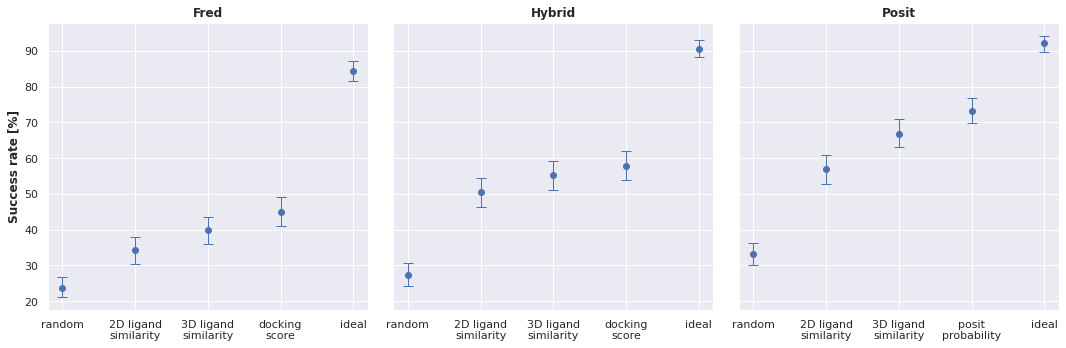

In [6]:
def plot_selection_strategies(fred_results, hybrid_results, posit_results, n_bootstrap=1000, ci=0.95, directory=OUT_DIR):
    
    # select pose 1 for Fred and Hybrid, i.e. best pose according to docking score
    fred_results = fred_results[fred_results["pose"] == 1]
    hybrid_results = hybrid_results[hybrid_results["pose"] == 1]
    
    # 3 subplots
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
    
    # sample data
    sampled_success_rates = []
    for i, (method, results) in enumerate(zip(["Fred", "Hybrid", "Posit"], [fred_results, hybrid_results, posit_results])):
        for selection_strategy in ["random", "2D ligand similarity", "3D ligand similarity", "score/probability", "ideal"]:
            if selection_strategy == "2D ligand similarity":
                selected_results = results.sort_values("fingerprint_similarity", ascending=False)
            elif selection_strategy == "3D ligand similarity":
                selected_results = results.sort_values("shape_similarity", ascending=False)
            elif selection_strategy == "score/probability":
                selected_results = results.sort_values("docking_score")
                if method == "Posit":
                    selected_results = selected_results.sort_values("posit_probability", ascending=False)
            elif selection_strategy == "ideal":
                selected_results = results.sort_values("rmsd")
            if selection_strategy != "random":
                selected_results = selected_results.groupby(["ligand_pdb_id"]).head(1)
                success_labels = (selected_results["rmsd"] <= 2).to_list()
            sampled_success_rates_i = []
            for _ in range(n_bootstrap):
                if selection_strategy == "random":
                    sampled_results = results.groupby("ligand_pdb_id").sample(n=1)
                    sampled_success_labels = (sampled_results["rmsd"] <= 2).to_list()
                else:
                    sampled_success_labels = resample(success_labels)
                sampled_success_rates_i.append((sum(sampled_success_labels) / len(sampled_success_labels)) * 100)
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            cutoff = (1 - ci) / 2
            success_rate_mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            ci_lower_bound = sampled_success_rates_i[int(n_bootstrap * cutoff)]
            ci_upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + cutoff))]
            sampled_success_rates.append([
                method,
                selection_strategy,
                success_rate_mean,
                ci_lower_bound,
                ci_upper_bound
            ])
            
    sampled_success_rates = pd.DataFrame(
        sampled_success_rates, columns=["method", "selection_strategy", "success_rate", "ci_lower", "ci_upper"]
    )
    
    # plot data
    for i, method in enumerate(["Fred", "Hybrid", "Posit"]):
        sampled_success_rates_i = sampled_success_rates[
            sampled_success_rates["method"] == method
        ]
        axes[i].errorbar(
            x=sampled_success_rates_i["selection_strategy"],
            y=sampled_success_rates_i["success_rate"],
            yerr=[
                sampled_success_rates_i["success_rate"] - sampled_success_rates_i["ci_lower"], 
                sampled_success_rates_i["ci_upper"] - sampled_success_rates_i["success_rate"]
            ],
            fmt="o",
            elinewidth=1,
            capsize=5,
            capthick=1
        )
        axes[i].set_xticks(["random", "2D ligand similarity", "3D ligand similarity", "score/probability", "ideal"])
        axes[i].set_xticklabels(["random", "2D ligand\nsimilarity", "3D ligand\nsimilarity", "docking\nscore", "ideal"])
        if method == "Posit":
            axes[i].set_xticklabels(["random", "2D ligand\nsimilarity", "3D ligand\nsimilarity", "posit\nprobability", "ideal"])
        axes[i].set_xlabel("", fontweight="bold")
        axes[i].set_title(method, fontweight="bold")
    axes[0].set_ylabel("Success rate [%]", fontweight="bold")
    
    plt.tight_layout()
    plt.savefig(directory / "selection_strategies.png", dpi=300)
    
    return sampled_success_rates


sampled_success_rates = plot_selection_strategies(fred_results, hybrid_results, posit_results)

In [7]:
sampled_success_rates

,method,selection_strategy,success_rate,ci_lower,ci_upper
0,Fred,random,23.782852,21.222411,26.655348
1,Fred,2D ligand similarity,34.238031,30.220713,37.860781
2,Fred,3D ligand similarity,39.756706,35.993209,43.633277
3,Fred,score/probability,44.869270,40.916808,49.066214
4,Fred,ideal,84.351104,81.494058,87.266553
5,Hybrid,random,27.258065,24.108659,30.560272
6,Hybrid,2D ligand similarity,50.455688,46.349745,54.499151
7,Hybrid,3D ligand similarity,55.247199,51.103565,59.252971
8,Hybrid,score/probability,57.894567,53.820034,61.969440
9,Hybrid,ideal,90.633786,88.285229,93.039049
